In [1]:
import scipy.io as scio
import os
import numpy as np
import sklearn.metrics as metrics
# from keras import layers
# from keras import models
import pandas as pd
# from sklearn.metrics import f1_score,recall_score,precision_score,auc,accuracy_score,confusion_matrix
# from sklearn.metrics import precision_recall_curve, average_precision_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
from scipy import interp
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D,Conv1D,Conv1DTranspose
from tensorflow.keras.layers import MaxPooling1D, Dropout, UpSampling1D,MaxPool2D,UpSampling2D
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# from tqdm import notebook
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D,Conv1D,Conv1DTranspose
from tensorflow.keras.layers import MaxPooling1D, Dropout, UpSampling1D,MaxPool2D,UpSampling2D
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# from tqdm import notebook
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
path='./CWRU/'
#寻找文件夹下所有的数据文件
path_list=os.listdir(path)
data_x=[]
data_y=[]
for i in path_list:
    path1=path+i
    dd=scio.loadmat(path1)
    for j in dd.keys():
        #只使用DE的数据
        if 'DE' in j:
            ddd=dd[j]
            #截前12W个数据
            data_x.append(ddd[:120000].ravel())
            data_y.append(i)

In [6]:
#切分成多个样本数据
def yuchuli(a,label):
    """
    前200个样本用于训练
    后100个样本用于测试
    """
    a  = a.reshape(300,400)
    np.random.shuffle(a)
    train = a[:200,:]
    test = a[200:,:]
    label_test =[label for i in range(0,100)]
    label_train = [label for i in range(0, 200)]
    return train,test,label_train ,label_test



#绘制P-R曲线
def micro_PR(y_test,y_score):
    # 对每一个类别计算性能指标
    precision = dict()
    recall = dict()
    average_precision = dict()
    # .shape会返回一个元组，存储行和列，取第二个数，也就是列
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        precision[i], recall[i], _ =  precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    precision["micro"],  recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
    return precision, recall, average_precision

def plot_a_model_PR_curve(precision,recall,average_precision,title=None,path=None):
    plt.figure(figsize=(6,6))
    for i in precision.keys():
        label = str(i)+"，AP = {0:0.4f}".format(average_precision[i])
        plt.step(recall[i], precision[i], where='post', lw=2,label=label)
    plt.legend()
    plt.xlabel("Recall", fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel("Precision", fontdict={'weight': 'normal', 'size': 15})
    if title != None:
        plt.title(title)
        
    if path!= None:
        plt.savefig(path,dpi=700)
    plt.show()

    
#将y转变为onehot向量
def to_one_hot(labels,label_dict):
    dimension=len(label_dict.keys())
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label_dict[label]] = 1
    return results

In [7]:
#将多条数据的所有样本合并起来
x_train,x_test,y_train,y_test=[],[],[],[]
for i in range(len(data_x)):
    train,test,label_train ,label_test=yuchuli(data_x[i],data_y[i])
    x_train+=list(train)
    x_test+=list(test)
    y_train+=label_train
    y_test+=label_test
    
#转换数据格式
x_train=np.array(x_train)
x_test=np.array(x_test)

#将x转变为二维矩阵，方便CNN训练
x_train = x_train.reshape(-1,400,1)
x_test = x_test.reshape(-1,400,1)

state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)

#转换y的数据格式
y_train=np.array(y_train)
y_test=np.array(y_test)

#生成label的字典，用于将y转换为onehot格式
label_dict={}
label_dict_anti={}
for i,j in enumerate(list(set(list(y_train)+list(y_test)))):
    label_dict[j]=i
    label_dict_anti[i]=j
    

one_hot_train_labels = to_one_hot(y_train,label_dict)
one_hot_test_labels = to_one_hot(y_test,label_dict)

y_test_transform=np.argmax(one_hot_test_labels,axis=1)
y_train_transform=np.argmax(one_hot_train_labels,axis=1)

input_shape=x_train.shape[1:]
output=one_hot_train_labels.shape[1]

In [ ]:
one_hot_train_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
x_train.shape,x_test.shape

((2000, 400, 1), (1000, 400, 1))

In [ ]:
y_train_transform.shape,y_test_transform.shape

((2000,), (1000,))

Model

In [ ]:
num_classes = len(np.unique(y_train_transform))
num_classes

10

In [9]:
# INPUT_DIMS = 40
# TIME_STEPS = 400
# lstm_units = 64
import keras.backend as K
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

In [10]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block2(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((1, 2))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [15]:
def attention_model():
    input_img = Input(shape=(400, 1))

    x= Conv1D(filters = 30, kernel_size = 10, activation = 'relu', padding = 'same')(input_img)
    # x = layers.LSTM(units=30,return_sequences=True)(x)
    # x = Flatten()(x)

    # y= Conv1D(filters = 60, kernel_size = 20, activation = 'relu', padding = 'same')(input_img)
    # y = layers.LSTM(units=30,return_sequences=True)(y)
    # y = Flatten()(y)

    # z= Conv1D(filters = 60, kernel_size = 30, activation = 'relu', padding = 'same')(input_img)
    # z = layers.LSTM(units=30,return_sequences=True)(z)
    # z = Flatten()(z)

    # inception_out=tf.concat([x,y,z],axis=-1)
    
    
    
    attention_mul = attention_3d_block2(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = LSTM(64, return_sequences=True)(attention_mul)





    # attention_mul = attention_3d_block2(inception_out)
    attention_mul = Flatten()(lstm_out)

    output = Dense(10, activation='softmax')(attention_mul)
    model = Model(inputs=input_img, outputs=output)
    return model

In [16]:
model=attention_model()

In [17]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])   

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 400, 30)      330         ['input_2[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 400, 30)      930         ['conv1d_1[0][0]']               
                                                                                                  
 permute_1 (Permute)            (None, 400, 30)      0           ['dense_2[0][0]']                
                                                                                            

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model5.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
history = model.fit(x_train, 
                            y_train_transform,
                          epochs=4,
                          batch_size=512,
                        #   shuffle=True,
                          validation_split=0.2,
                          verbose=1, 
                          callbacks=callbacks).history

Epoch 1/4
4/4 [==============================] - 17s 4s/step - loss: 1.7391 - sparse_categorical_accuracy: 0.3494 - val_loss: 1.6931 - val_sparse_categorical_accuracy: 0.3925 - lr: 0.0010
Epoch 2/4
4/4 [==============================] - 18s 4s/step - loss: 1.6904 - sparse_categorical_accuracy: 0.3462 - val_loss: 1.6406 - val_sparse_categorical_accuracy: 0.3275 - lr: 0.0010
Epoch 3/4
4/4 [==============================] - 18s 4s/step - loss: 1.6118 - sparse_categorical_accuracy: 0.3400 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.3425 - lr: 0.0010
Epoch 4/4
4/4 [==============================] - 19s 4s/step - loss: 1.5595 - sparse_categorical_accuracy: 0.3819 - val_loss: 1.5734 - val_sparse_categorical_accuracy: 0.3600 - lr: 0.0010


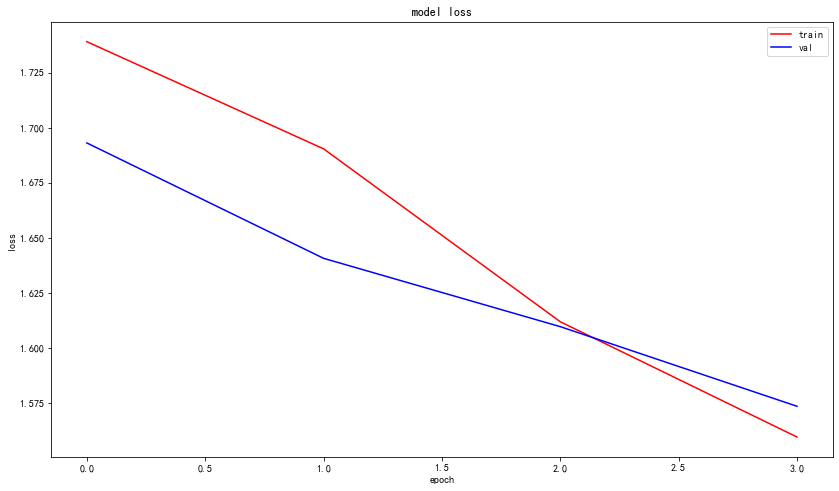

In [23]:
import seaborn as sns
# # plt.figure(figsize=(14, 5))
# plt.subplot(121)
plt.figure(figsize=(14,8))
# # sns.set(font_scale = 0.5)
plt.plot(history['loss'][:], c='red')
plt.plot(history['val_loss'][:], c='blue')
plt.title('model loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

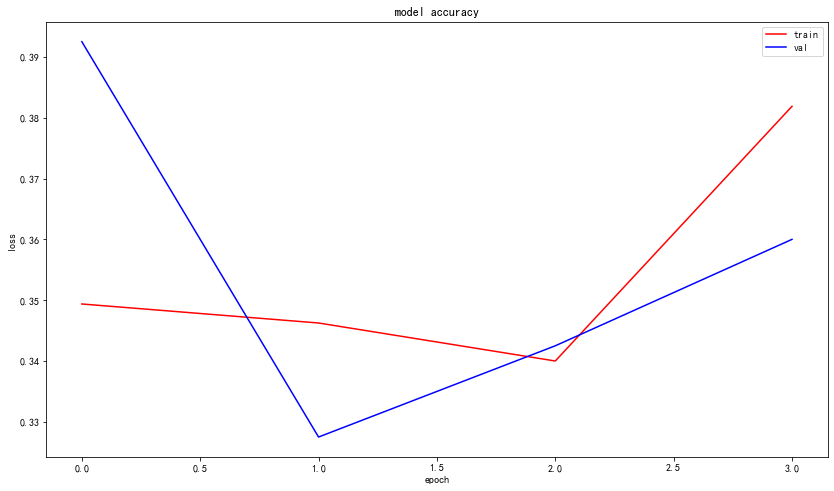

In [24]:
import seaborn as sns
# # plt.figure(figsize=(14, 5))
# plt.subplot(121)
plt.figure(figsize=(14,8))
# # sns.set(font_scale = 0.5)
plt.plot(history['sparse_categorical_accuracy'][:], c='red')
plt.plot(history['val_sparse_categorical_accuracy'][:], c='blue')
plt.title('model accuracy')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [25]:
df=pd.DataFrame(history)
df

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr
0,1.739056,0.349375,1.693059,0.3925,0.001
1,1.690389,0.346250,1.640648,0.3275,0.001
2,1.611828,0.340000,1.609601,0.3425,0.001
3,1.559459,0.381875,1.573433,0.3600,0.001


In [26]:
df.to_csv('model6.csv',index=None)

In [27]:
pred_test =model.predict(x_test)

In [28]:
pre=np.argmax(pred_test,axis=1)

In [29]:
test_y=np.argmax(one_hot_test_labels,axis=1)

In [30]:
correct_prediction = tf.equal(pre, test_y)
acc = tf.reduce_mean(tf.cast(correct_prediction, "float"))
acc=float(acc)
# f1=metrics.f1_

In [31]:
acc

0.3970000147819519